In [66]:
%matplotlib inline
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import datetime
import pymc as pm
# from mpl_toolkits.basemap import Basemap
# from matplotlib.patches import Polygon

#set default plot characterstics and colors
from matplotlib import rcParams

import prep_data

dark_colors = ["#99D699", "#B2B2B2",
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 8)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = "white"
rcParams['axes.titlesize'] = 20      
rcParams['axes.labelsize'] = 17.5
rcParams['xtick.labelsize'] = 15 
rcParams['ytick.labelsize'] = 15
rcParams['legend.fontsize'] = 17.5
rcParams['patch.edgecolor'] = 'none'
rcParams['grid.color']="white"   
rcParams['grid.linestyle']="-" 
rcParams['grid.linewidth'] = 1
rcParams['grid.alpha']=1
rcParams['text.color'] = "444444"
rcParams['axes.labelcolor'] = "444444"
rcParams['ytick.color'] = "444444"
rcParams['xtick.color'] = "444444"

# import findspark
# findspark.init()
# import pyspark
# sc = pyspark.SparkContext(appName="Spark1")

In [2]:
stations_df = prep_data.stations('https://raw.githubusercontent.com/CS109Hubway/classp/master/data/hubway_stations.csv')
stations_df.head()

,id,terminal,station,municipal,lat,lng,status
0,3,B32006,Colleges of the Fenway,Boston,42.340021,-71.100812,Existing
1,4,C32000,Tremont St. at Berkeley St.,Boston,42.345392,-71.069616,Existing
2,5,B32012,Northeastern U / North Parking Lot,Boston,42.341814,-71.090179,Existing
3,6,D32000,Cambridge St. at Joy St.,Boston,42.361285,-71.065140,Existing
4,7,A32000,Fan Pier,Boston,42.353412,-71.044624,Existing


In [3]:
trips_df = prep_data.trips('https://raw.githubusercontent.com/CS109Hubway/classp/master/data/tripsthrough2012.csv')
trips_df.head()

,index,seq_id,hubway_id,status,duration,start_date,strt_statn,end_date,end_statn,bike_nr,...,st_hour,end_hour,st_minute,end_minute,st_month,end_month,st_daydate,end_daydate,st_weekday,end_weekday
0,140521,140522,157655,Closed,189,2012-03-13 18:31:00,29,2012-03-13 18:34:00,18,B00094,...,18,18,1111,1114,3,3,2012-03-13,2012-03-13,1,1
1,140522,140524,157657,Closed,704,2012-03-15 00:00:00,40,2012-03-15 00:12:00,40,B00082,...,0,0,0,12,3,3,2012-03-15,2012-03-15,3,3
2,140523,140523,157656,Closed,1700,2012-03-15 00:00:00,7,2012-03-15 00:28:00,15,B00603,...,0,0,0,28,3,3,2012-03-15,2012-03-15,3,3
3,140524,140525,157658,Closed,1411,2012-03-15 00:00:00,41,2012-03-15 00:24:00,36,B00278,...,0,0,0,24,3,3,2012-03-15,2012-03-15,3,3
4,140525,140526,157659,Closed,251,2012-03-15 00:03:00,43,2012-03-15 00:07:00,40,B00076,...,0,0,3,7,3,3,2012-03-15,2012-03-15,3,3


In [4]:
for index, row in trips_df.iterrows():
    print row
    break

index                       140521
seq_id                      140522
hubway_id                   157655
status                      Closed
duration                       189
start_date     2012-03-13 18:31:00
strt_statn                      29
end_date       2012-03-13 18:34:00
end_statn                       18
bike_nr                     B00094
subsc_type              Registered
zip_code                    '02446
birth_date                    1988
gender                      Female
st_hour                         18
end_hour                        18
st_minute                     1111
end_minute                    1114
st_month                         3
end_month                        3
st_daydate              2012-03-13
end_daydate             2012-03-13
st_weekday                       1
end_weekday                      1
Name: 0, dtype: object


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


In [35]:
day_set = set(trips_df.st_daydate.tolist())
day_set |= set(trips_df.end_daydate.tolist())
day_set = sorted(list(day_set))

In [36]:
print trips_df.st_daydate.max()
print trips_df.st_daydate.min()
print len(trips_df.st_daydate.unique())
print trips_df.strt_statn.max()

2012-11-28
2012-03-13
260
141.0


In [45]:
out_minutes_series = np.zeros([trips_df.strt_statn.max() + 1,len(trips_df.st_daydate.unique())*24*60])
in_minutes_series = np.zeros([trips_df.end_statn.max() + 1,len(trips_df.end_daydate.unique())*24*60])

for index, row in trips_df.iterrows():
    print "\r" + str(index),
    
    if row[6] != row[6]:
        continue
    
    st_station  = row[6]
    st_minute   = row[16]
    st_day = day_set.index(row[20])    

    out_minutes_series[st_station,st_day*24*60 + st_minute] += 1

    if row[8] != row[8]:
        continue

    end_station = row[8]
    end_minute  = row[17]    
    end_day = day_set.index(row[21])
    
    in_minutes_series[end_station, end_day*24*60 + end_minute] += 1


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


533828


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


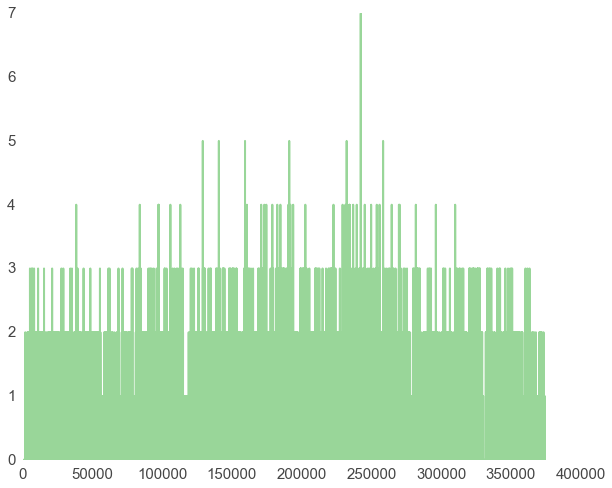

In [51]:
plt.plot(out_minutes_series[22,:])

In [63]:
min_per_interval = 30
ints = 0
timeseries_matrix_30minute_out = np.zeros(len(out_minutes_series[22,:])/min_per_interval)
while ints < len(timeseries_matrix_10minute_out):
    int_sum = 0
    for i in range(min_per_interval):
        int_sum += out_minutes_series[22,ints*min_per_interval + i]
    timeseries_matrix_30minute_out[ints] = int_sum
    ints +=1

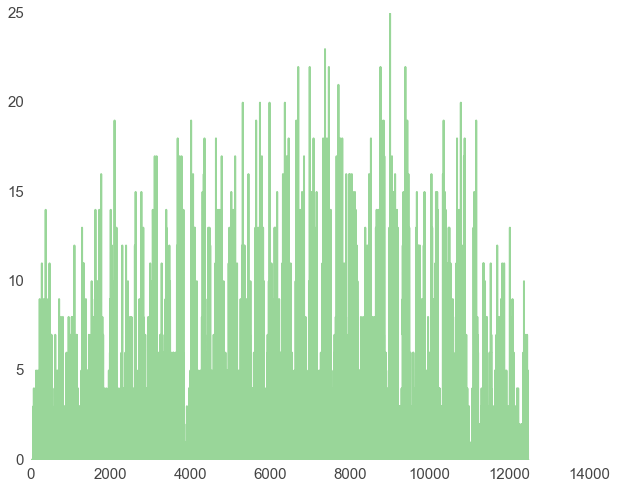

In [64]:
plt.plot(timeseries_matrix_30minute_out)

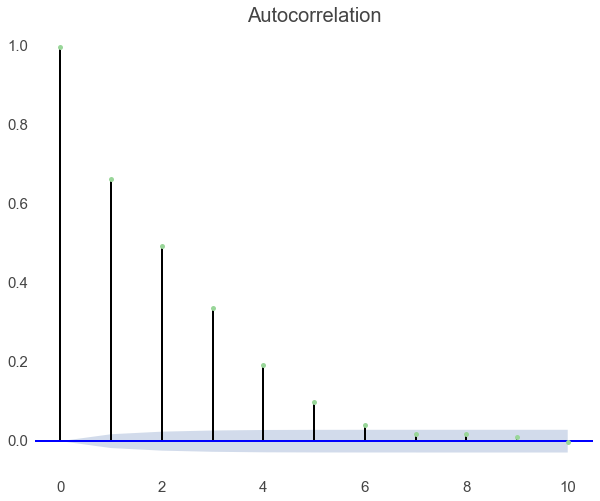

In [65]:
tsaplots.plot_acf(timeseries_matrix_30minute_out, lags=10);

In [ ]:
#estimate these
N = len(timeseries_matrix_30minute_out[:500])

# a1n(xn-1) + a2n(xn-2) + a3n(xn-3) +a4n(xn-4) + a5n(xn-5) + a6n(xn-6)

alphas = pm.Container([pm.Uniform('alpha_%i' %i,lower = -10,upper = 10) for i in range((N-6)*6)])

sigma_squared = pm.Uniform('sigma_squared',lower=0,upper=10)

mus = pm.Container([alphas[i]*timeseries_matrix_30minute_out[i-1] + \
                    alphas[i+1]*timeseries_matrix_30minute_out[i-2] + \
                    alphas[i+2]*timeseries_matrix_30minute_out[i-3] + \
                    alphas[i+3]*timeseries_matrix_30minute_out[i-4] + \
                    alphas[i+4]*timeseries_matrix_30minute_out[i-5] + \
                    alphas[i+5]*timeseries_matrix_30minute_out[i-6] \
                    for i in range(6,N)])

#init_likelihood = pm.Normal('init_likelihood', mu = 0, tau = 1/sigma_squared, value = timeseries_matrix_30minute_out[0], observed = True)

likelihood = pm.Container([pm.Normal('likelihood_%i' %i, mu = mus[i-6], tau = 1.0/sigma_squared, value = timeseries_matrix_30minute_out[i], observed = True) for i in range (6,N)])

posterior = pm.Model([alphas, mus, sigma_squared, likelihood])

mcmc = pm.MCMC(posterior)
mcmc.sample(iter=5000,burn=500)

 [                  1%                  ] 93 of 5000 complete in 11.9 sec